In [139]:
import pandas as pd
from braincoder.models import GaussianPRF
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Fit encoding model

In [140]:
parameters = pd.DataFrame({'mu':[3, 6, 8], 'sd':[1., 1. ,1.],
                           'baseline':[0.0, 0.0, 0.0], 'amplitude':[1.5, 2., 1.]})

paradigm = np.linspace(2, 10, 50)

In [141]:
model = GaussianPRF(parameters=parameters, paradigm=paradigm)

In [142]:
data = model.simulate(noise=.15)

(1, 50, 3)


<AxesSubplot:xlabel='time'>

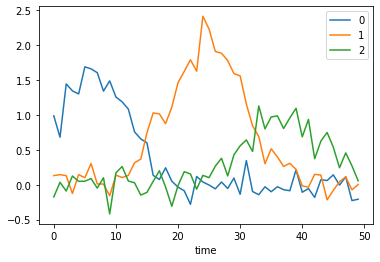

In [143]:
data.plot()

In [144]:
from braincoder.optimize import ParameterFitter

In [145]:
fitter = ParameterFitter(model, data, paradigm)

Now we fit the parameters using a fit search

In [146]:
pars_grid = fitter.fit_grid(mu=np.linspace(0, 10, 11), 
                sd=np.linspace(.1, 3., 10),
                amplitude=np.arange(0.0, 5.0, .5),
                baseline=[-1.0, 0.0, 1.0])
pars_grid

  0%|          | 0/1 [00:00<?, ?it/s]

Working with chunk size of 4444444


100%|██████████| 1/1 [00:00<00:00, 17.15it/s]


,mu,sd,amplitude,baseline
0,3.0,1.066667,1.5,0.0
1,6.0,1.066667,2.0,0.0
2,8.0,1.066667,1.0,0.0


This is already pretty good.

Noter that we can be much faster (this becomes important when we have 10,000s of voxels and more complex models) by using a _correlation_ cost function. The amplitude and baseline have no effect on the cost function then (except when amplitude= 0.0).

In [147]:
pars_grid = fitter.fit_grid(mu=np.linspace(0, 10, 11), 
                sd=np.linspace(.1, 3., 10),
                amplitude=[1.0],
                baseline=[0.0], use_correlation_cost=True)

pars_grid

  0%|          | 0/1 [00:00<?, ?it/s]

Working with chunk size of 4444444
Using correlation cost!


100%|██████████| 1/1 [00:00<00:00, 12.28it/s]


,mu,sd,amplitude,baseline
0,1.0,0.100000,1.0,0.0
1,6.0,1.066667,1.0,0.0
2,8.0,1.066667,1.0,0.0


We cann now fit the amplitude and baseline using a OLS GLM

In [148]:
refined_pars = fitter.refine_baseline_and_amplitude(pars_grid)

(50, 3)
Original mean r2: 0.32975292205810547
(50, 3)
100.00% of time lines improved
(50, 3)
New mean r2 after OLS: 0.5946799516677856
(50, 3)
Original mean r2: 0.5946799516677856
(50, 3)
0.00% of time lines improved
(50, 3)
New mean r2 after OLS: 0.5946799516677856


In [149]:
refined_pars

,mu,sd,amplitude,baseline
0,1.0,0.100000,1.453862e-24,0.376891
1,6.0,1.066667,1.992519e+00,-0.029649
2,8.0,1.066667,9.654410e-01,-0.009407


Finally, we want to get the best possible parameters using gradient descent

In [150]:
best_pars = fitter.fit(init_pars=refined_pars)
best_pars

  0%|          | 0/1000 [00:00<?, ?it/s]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 3


Current R2: 0.59829/Best R2: 0.59829:  15%|█▌        | 154/1000 [00:01<00:06, 122.13it/s]


(50, 3)


parameter,mu,sd,amplitude,baseline
0,1.000000,0.100000,1.453864e-24,0.377062
1,6.034132,0.944631,2.029020e+00,0.034400
2,8.058611,1.045964,9.684378e-01,-0.004080


# Estimate noise covariance

Now we can apply the van Bergen et al. decoding approach. The first step is to get an $\Omega$ matrix that describes the covariance of the _residuals_.

In [151]:
from braincoder.optimize import ResidualFitter

In [152]:
stimulus_range = np.linspace(0, 10, 50)

wwt = model.init_pseudoWWT(stimulus_range, best_pars)

In [153]:
resid_fitter = ResidualFitter(model, data, paradigm=paradigm)

omega, dof = resid_fitter.fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

(50, 3)
init_tau: 0.14912474155426025, 0.15518486499786377
USING A PSEUDO-WWT!
WWT max: 35.45458221435547


fit stat: -69.3007 (best: -69.3007, rho: 0.029, sigma2: 0.000, mean tau: 0.1522: 100%|██████████| 1000/1000 [00:05<00:00, 182.29it/s]


In [154]:
import seaborn as sns

The fitter correctly determines that there is (almost) no covariance between the noise in the voxels.

<AxesSubplot:>

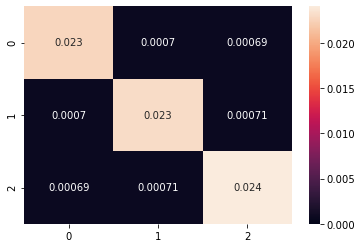

In [155]:
sns.heatmap(omega, vmin=0, vmax=None, annot=True)

Let's try to make some correlated noise

In [156]:
import scipy.stats as ss

In [157]:
# We predict data without any noise and add correlated noise
data = model.predict()

cov = np.identity(3) * .075
cov += .0375

data += ss.multivariate_normal(np.zeros(3), cov).rvs(50).astype(np.float32)

(50, 3)


In [158]:
data.corr()

,0,1,2
0,1.000000,-0.249925,-0.140141
1,-0.249925,1.000000,-0.009475
2,-0.140141,-0.009475,1.000000


In [159]:
#Set up fitter
fitter = ParameterFitter(model, data, paradigm)

# Grid fit
pars_grid = fitter.fit_grid(mu=np.linspace(0, 10, 11), 
                sd=np.linspace(.1, 3., 10),
                amplitude=[1.0],
                baseline=[0.0], use_correlation_cost=True)

# Refine using OLS
refined_pars = fitter.refine_baseline_and_amplitude(pars_grid)

# Gradient descent
best_pars = fitter.fit(init_pars=refined_pars)

# Determine overlap in RFs (WWT)
wwt = model.init_pseudoWWT(stimulus_range, best_pars)

  0%|          | 0/1 [00:00<?, ?it/s]

Working with chunk size of 4444444
Using correlation cost!


  0%|          | 0/1000 [00:00<?, ?it/s]

(50, 3)
Original mean r2: 0.20476071536540985
(50, 3)
100.00% of time lines improved
(50, 3)
New mean r2 after OLS: 0.4681987762451172
(50, 3)
Original mean r2: 0.4681987762451172
(50, 3)
0.00% of time lines improved
(50, 3)
New mean r2 after OLS: 0.4681987762451172
Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 3


Current R2: 0.47554/Best R2: 0.47554:  16%|█▋        | 163/1000 [00:01<00:06, 135.31it/s]


(50, 3)


In [160]:
resid_fitter = ResidualFitter(model, data.astype(np.float32), paradigm=paradigm.astype(np.float32))
omega, dof = resid_fitter.fit()

  0%|          | 0/1000 [00:00<?, ?it/s]

(50, 3)
init_tau: 0.33381643891334534, 0.350383996963501
USING A PSEUDO-WWT!
WWT max: 36.805885314941406


fit stat: 42.1013 (best: 42.1013, rho: 0.424, sigma2: 0.032, mean tau: 0.2393:  43%|████▎     | 433/1000 [00:02<00:03, 161.41it/s]


<AxesSubplot:>

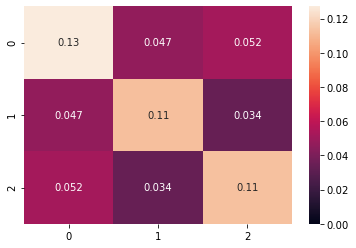

In [161]:
sns.heatmap(omega, vmin=0, vmax=None, annot=True)

# Decode unseen data

Let's simulate some unseen data

In [162]:
# We predict data without any noise and add correlated noise
unseen_data = model.predict()
unseen_data += ss.multivariate_normal(np.zeros(3), cov).rvs(50).astype(np.float32)

(50, 3)


<AxesSubplot:xlabel='time'>

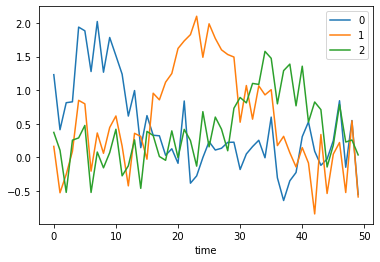

In [163]:
unseen_data.plot()

In [164]:
from braincoder.optimize import StimulusFitter

We evaluate the likelihood across a range of potential stimuli

In [165]:
paradigm

array([ 2.        ,  2.16326531,  2.32653061,  2.48979592,  2.65306122,
        2.81632653,  2.97959184,  3.14285714,  3.30612245,  3.46938776,
        3.63265306,  3.79591837,  3.95918367,  4.12244898,  4.28571429,
        4.44897959,  4.6122449 ,  4.7755102 ,  4.93877551,  5.10204082,
        5.26530612,  5.42857143,  5.59183673,  5.75510204,  5.91836735,
        6.08163265,  6.24489796,  6.40816327,  6.57142857,  6.73469388,
        6.89795918,  7.06122449,  7.2244898 ,  7.3877551 ,  7.55102041,
        7.71428571,  7.87755102,  8.04081633,  8.20408163,  8.36734694,
        8.53061224,  8.69387755,  8.85714286,  9.02040816,  9.18367347,
        9.34693878,  9.51020408,  9.67346939,  9.83673469, 10.        ])

In [166]:
posterior = model.get_stimulus_pdf(data=unseen_data, stimulus_range=np.linspace(2, 10, 50, dtype=np.float32),
                                  parameters=best_pars, omega=omega)

<AxesSubplot:xlabel='stimulus', ylabel='time'>

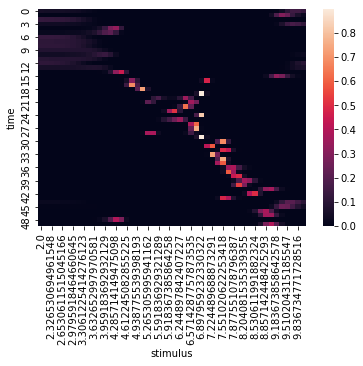

In [167]:
sns.heatmap(posterior)

Expected value of the posterior across time

In [168]:
EV = (posterior * posterior.columns).sum(1)

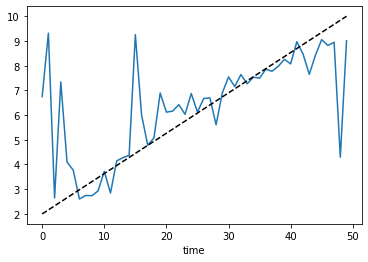

In [169]:
EV.plot()
plt.plot(paradigm, c='k', ls='--')

Standard deviation of the posterior across time. Especially around the edges of the paradigm, where there is only little overlap with the RFs, the posterior sd becomes larger.

<AxesSubplot:xlabel='time'>

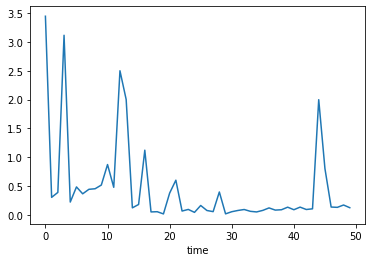

In [170]:
sd = (posterior * np.abs((posterior.columns.values[np.newaxis, :] - EV.values[:, np.newaxis]))).sum(1)

sd.plot()

In [171]:
error = EV - paradigm

The sd of the posterior is mildly predictive of the actual error of the EV

In [172]:
tmp = pd.DataFrame({'abs(error)':np.abs(error), 'sd posterior':sd})

In [174]:
import pingouin

In [ ]:
pinoguin.corr(tmp['abs(error)'], tmp['sd'])

/Users/gdehol/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


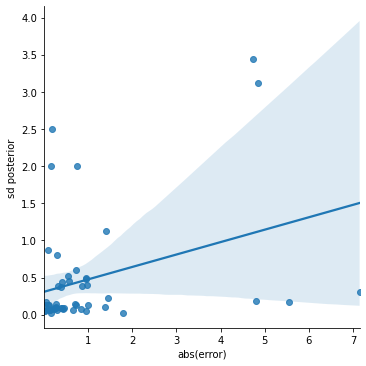

In [173]:
sns.lmplot('abs(error)', 'sd posterior', data=tmp.reset_index())